# Follow-Me Project
Congratulations on reaching the final project of the Robotics Nanodegree! 

Previously, you worked on the Semantic Segmentation lab where you built a deep learning network that locates a particular human target within an image. For this project, you will utilize what you implemented and learned from that lab and extend it to train a deep learning model that will allow a simulated quadcopter to follow around the person that it detects! 

Most of the code below is similar to the lab with some minor modifications. You can start with your existing solution, and modify and improve upon it to train the best possible model for this task.

You can click on any of the following to quickly jump to that part of this notebook:
1. [Data Collection](#data)
2. [FCN Layers](#fcn)
3. [Build the Model](#build)
4. [Training](#training)
5. [Prediction](#prediction)
6. [Evaluation](#evaluation)

## Data Collection<a id='data'></a>
We have provided you with a starting dataset for this project. Download instructions can be found in the README for this project's repo.
Alternatively, you can collect additional data of your own to improve your model. Check out the "Collecting Data" section in the Project Lesson in the Classroom for more details!

In [1]:
import os
import glob
import sys
import tensorflow as tf

from scipy import misc
import numpy as np

from tensorflow.contrib.keras.python import keras
from tensorflow.contrib.keras.python.keras import layers, models

from tensorflow import image

from utils import scoring_utils
from utils.separable_conv2d import SeparableConv2DKeras, BilinearUpSampling2D
from utils import data_iterator
from utils import plotting_tools 
from utils import model_tools

## FCN Layers <a id='fcn'></a>
In the Classroom, we discussed the different layers that constitute a fully convolutional network (FCN). The following code will introduce you to the functions that you need to build your semantic segmentation model.

### Separable Convolutions
The Encoder for your FCN will essentially require separable convolution layers, due to their advantages as explained in the classroom. The 1x1 convolution layer in the FCN, however, is a regular convolution. Implementations for both are provided below for your use. Each includes batch normalization with the ReLU activation function applied to the layers. 

In [2]:
def separable_conv2d_batchnorm(input_layer, filters, strides=1):
    output_layer = SeparableConv2DKeras(filters=filters,kernel_size=3, strides=strides,
                             padding='same', activation='relu')(input_layer)
    
    output_layer = layers.BatchNormalization()(output_layer) 
    return output_layer

def conv2d_batchnorm(input_layer, filters, kernel_size=3, strides=1):
    output_layer = layers.Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, 
                      padding='same', activation='relu')(input_layer)
    
    output_layer = layers.BatchNormalization()(output_layer) 
    return output_layer

### Bilinear Upsampling
The following helper function implements the bilinear upsampling layer. Upsampling by a factor of 2 is generally recommended, but you can try out different factors as well. Upsampling is used in the decoder block of the FCN.

In [3]:
def bilinear_upsample(input_layer):
    output_layer = BilinearUpSampling2D((2,2))(input_layer)
    return output_layer

## Build the Model <a id='build'></a>
In the following cells, you will build an FCN to train a model to detect and locate the hero target within an image. The steps are:
- Create an `encoder_block`
- Create a `decoder_block`
- Build the FCN consisting of encoder block(s), a 1x1 convolution, and decoder block(s).  This step requires experimentation with different numbers of layers and filter sizes to build your model.

### Encoder Block
Create an encoder block that includes a separable convolution layer using the `separable_conv2d_batchnorm()` function. The `filters` parameter defines the size or depth of the output layer. For example, 32 or 64. 

In [4]:
def encoder_block(input_layer, filters, strides):
    
    output_layer = separable_conv2d_batchnorm(input_layer, filters, strides)
    
    return output_layer

### Decoder Block
The decoder block is comprised of three parts:
- A bilinear upsampling layer using the upsample_bilinear() function. The current recommended factor for upsampling is set to 2.
- A layer concatenation step. This step is similar to skip connections. You will concatenate the upsampled small_ip_layer and the large_ip_layer.
- Some (one or two) additional separable convolution layers to extract some more spatial information from prior layers.

In [22]:
def decoder_block(small_ip_layer, large_ip_layer, filters):
    
    output_layer = bilinear_upsample(small_ip_layer)
    
    output_layer = layers.concatenate([output_layer, large_ip_layer])
    
    output_layer = separable_conv2d_batchnorm(output_layer, filters)
    output_layer = separable_conv2d_batchnorm(output_layer, filters)
    
    return output_layer

### Model

Now that you have the encoder and decoder blocks ready, go ahead and build your FCN architecture! 

There are three steps:
- Add encoder blocks to build the encoder layers. This is similar to how you added regular convolutional layers in your CNN lab.
- Add a 1x1 Convolution layer using the conv2d_batchnorm() function. Remember that 1x1 Convolutions require a kernel and stride of 1.
- Add decoder blocks for the decoder layers.

In [24]:
def fcn_model(inputs, num_classes):
    
    enc_layer1 = encoder_block(inputs, 64, 2)
    enc_layer2 = encoder_block(enc_layer1, 128, 2)
    #enc_layer3 = encoder_block(enc_layer2, 128, 2)
    #enc_layer4 = encoder_block(enc_layer3, 256, 2)

    # TODO Add 1x1 Convolution layer using conv2d_batchnorm().
    one_conv = conv2d_batchnorm(enc_layer2, 256, 1, 1)
    
    # TODO: Add the same number of Decoder Blocks as the number of Encoder Blocks
    dec_layer1 = decoder_block(one_conv, enc_layer1, 128)
    x = decoder_block(dec_layer1, inputs, 64)
    #dec_layer3 = decoder_block(dec_layer2, enc_layer1, 64)
    #x = decoder_block(dec_layer3, inputs, 32)
    
    # The function returns the output layer of your model. "x" is the final layer obtained from the last decoder_block()
    return layers.Conv2D(num_classes, 1, activation='softmax', padding='same')(x)

## Training <a id='training'></a>
The following cells will use the FCN you created and define an ouput layer based on the size of the processed image and the number of classes recognized. You will define the hyperparameters to compile and train your model.

Please Note: For this project, the helper code in `data_iterator.py` will resize the copter images to 160x160x3 to speed up training.

In [25]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""

image_hw = 160
image_shape = (image_hw, image_hw, 3)
inputs = layers.Input(image_shape)
num_classes = 3

# Call fcn_model()
output_layer = fcn_model(inputs, num_classes)

### Hyperparameters
Define and tune your hyperparameters.
- **batch_size**: number of training samples/images that get propagated through the network in a single pass.
- **num_epochs**: number of times the entire training dataset gets propagated through the network.
- **steps_per_epoch**: number of batches of training images that go through the network in 1 epoch. We have provided you with a default value. One recommended value to try would be based on the total number of images in training dataset divided by the batch_size.
- **validation_steps**: number of batches of validation images that go through the network in 1 epoch. This is similar to steps_per_epoch, except validation_steps is for the validation dataset. We have provided you with a default value for this as well.
- **workers**: maximum number of processes to spin up. This can affect your training speed and is dependent on your hardware. We have provided a recommended value to work with. 

In [26]:
learning_rate = 0.005
batch_size = 32
num_epochs = 100
steps_per_epoch = 100
validation_steps = 50
workers = 4

Epoch 1/100
 99/100 [============================>.] - ETA: 0s - loss: 0.2467

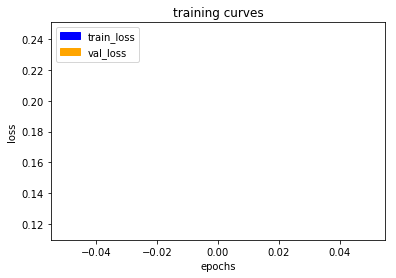

100/100 [==============================] - 101s - loss: 0.2447 - val_loss: 0.1159
Epoch 2/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0545

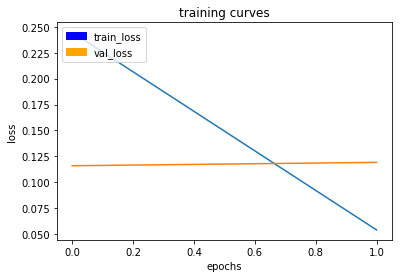

100/100 [==============================] - 100s - loss: 0.0544 - val_loss: 0.1192
Epoch 3/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0445

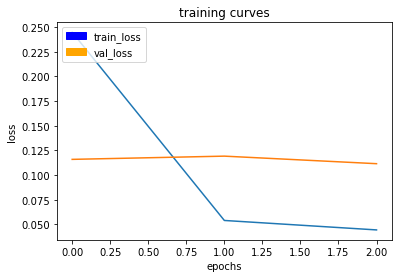

100/100 [==============================] - 100s - loss: 0.0444 - val_loss: 0.1116
Epoch 4/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0425

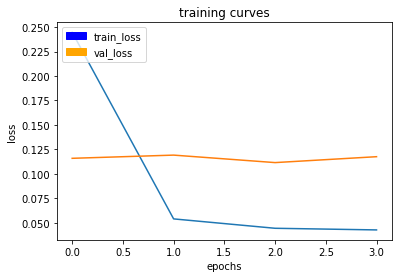

100/100 [==============================] - 100s - loss: 0.0427 - val_loss: 0.1176
Epoch 5/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0375

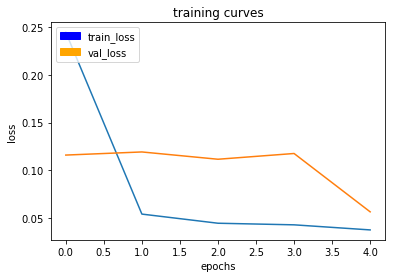

100/100 [==============================] - 101s - loss: 0.0375 - val_loss: 0.0564
Epoch 6/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0348

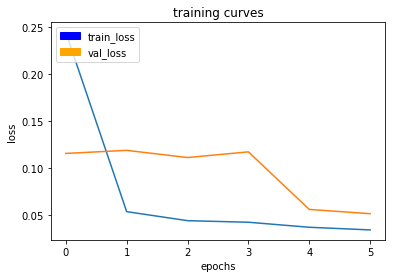

100/100 [==============================] - 101s - loss: 0.0348 - val_loss: 0.0519
Epoch 7/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0346

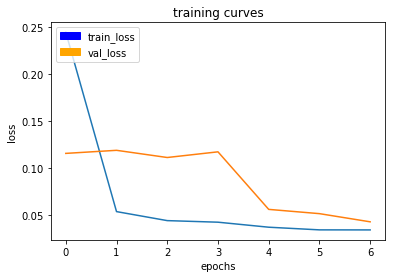

100/100 [==============================] - 101s - loss: 0.0345 - val_loss: 0.0432
Epoch 8/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0337

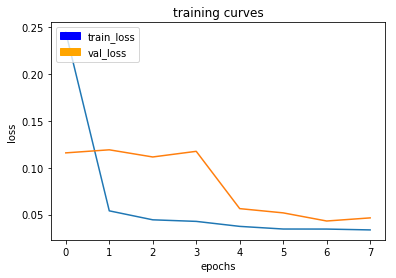

100/100 [==============================] - 100s - loss: 0.0336 - val_loss: 0.0465
Epoch 9/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0334

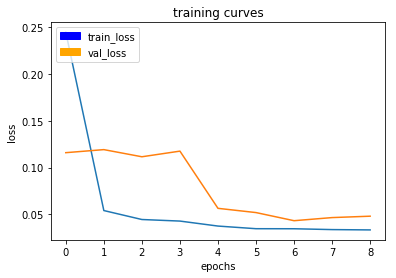

100/100 [==============================] - 101s - loss: 0.0334 - val_loss: 0.0480
Epoch 10/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0310

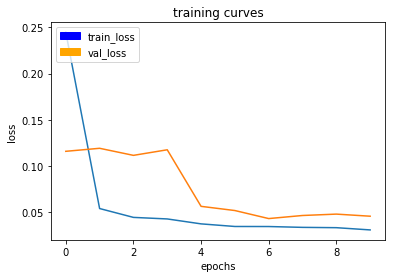

100/100 [==============================] - 100s - loss: 0.0309 - val_loss: 0.0458
Epoch 11/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0330

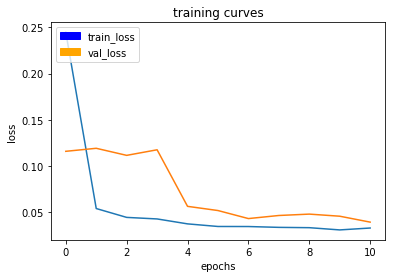

100/100 [==============================] - 101s - loss: 0.0329 - val_loss: 0.0394
Epoch 12/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0269

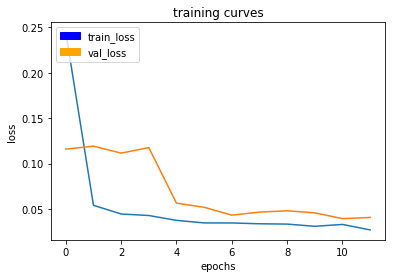

100/100 [==============================] - 100s - loss: 0.0269 - val_loss: 0.0406
Epoch 13/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0261

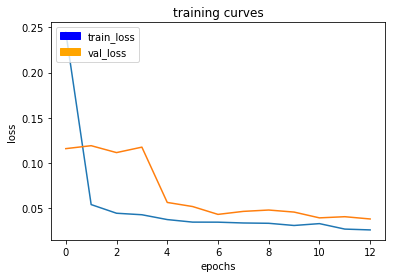

100/100 [==============================] - 101s - loss: 0.0260 - val_loss: 0.0381
Epoch 14/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0259

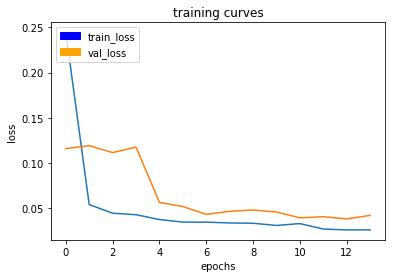

100/100 [==============================] - 101s - loss: 0.0260 - val_loss: 0.0421
Epoch 15/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0270

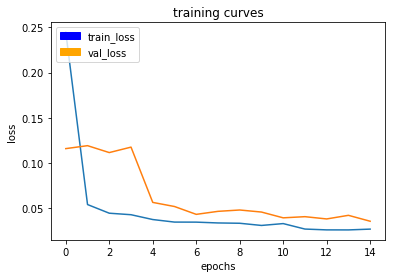

100/100 [==============================] - 101s - loss: 0.0269 - val_loss: 0.0356
Epoch 16/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0258

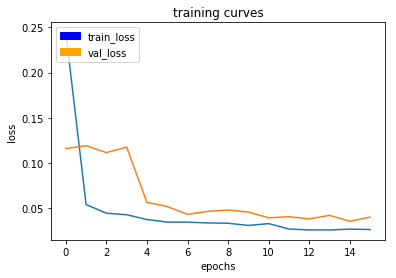

100/100 [==============================] - 101s - loss: 0.0263 - val_loss: 0.0402
Epoch 17/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0264

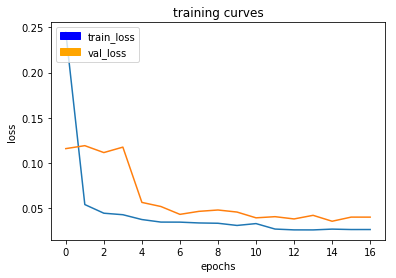

100/100 [==============================] - 100s - loss: 0.0264 - val_loss: 0.0401
Epoch 18/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0241

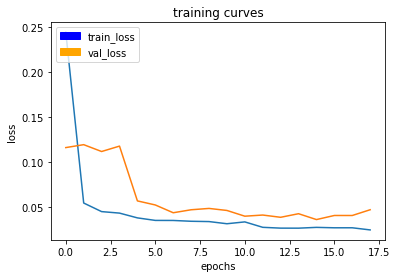

100/100 [==============================] - 101s - loss: 0.0240 - val_loss: 0.0466
Epoch 19/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0252

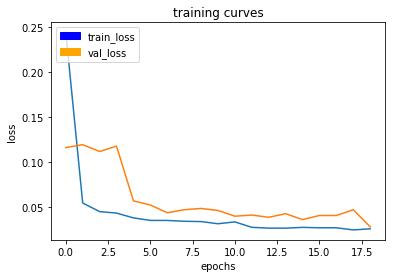

100/100 [==============================] - 101s - loss: 0.0253 - val_loss: 0.0275
Epoch 20/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0212

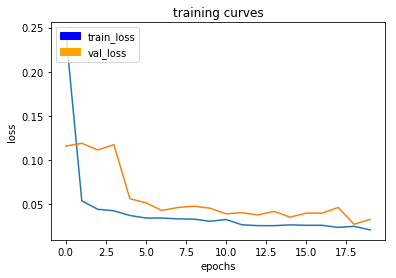

100/100 [==============================] - 100s - loss: 0.0211 - val_loss: 0.0331
Epoch 21/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0242

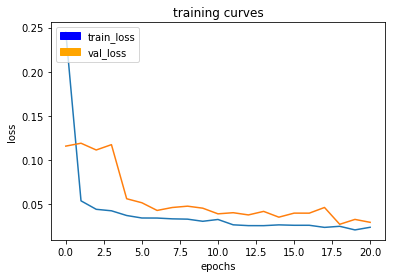

100/100 [==============================] - 100s - loss: 0.0242 - val_loss: 0.0298
Epoch 22/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0241

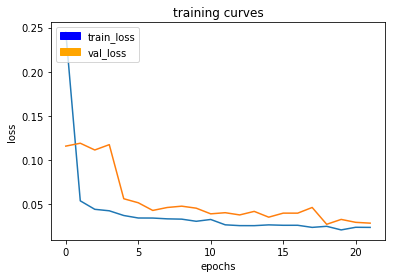

100/100 [==============================] - 101s - loss: 0.0240 - val_loss: 0.0288
Epoch 23/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0218

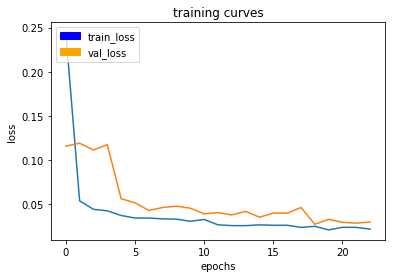

100/100 [==============================] - 101s - loss: 0.0220 - val_loss: 0.0302
Epoch 24/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0228

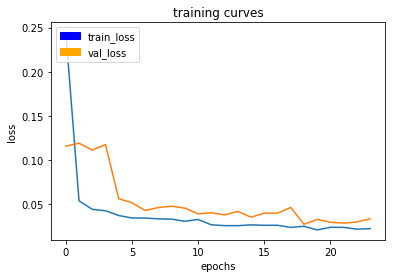

100/100 [==============================] - 100s - loss: 0.0227 - val_loss: 0.0337
Epoch 25/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0226

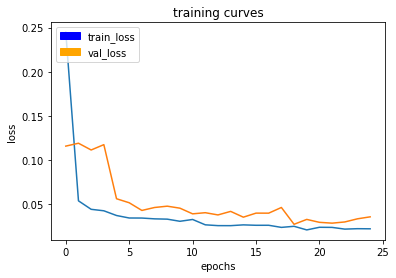

100/100 [==============================] - 100s - loss: 0.0226 - val_loss: 0.0360
Epoch 26/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0214

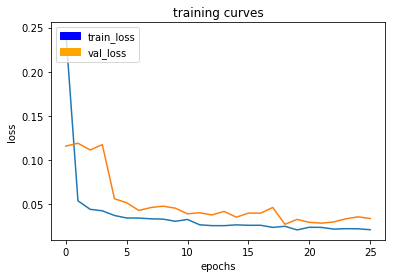

100/100 [==============================] - 101s - loss: 0.0214 - val_loss: 0.0341
Epoch 27/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0209

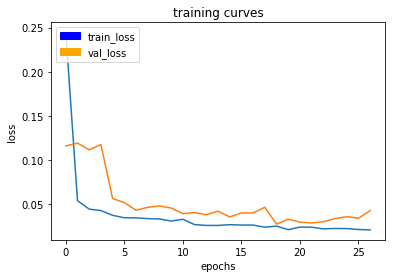

100/100 [==============================] - 101s - loss: 0.0209 - val_loss: 0.0428
Epoch 28/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0242

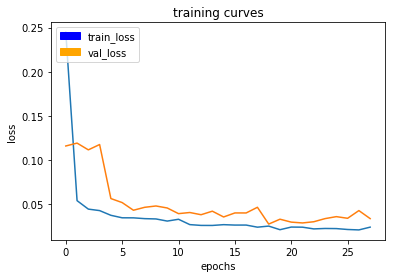

100/100 [==============================] - 101s - loss: 0.0241 - val_loss: 0.0337
Epoch 29/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0227

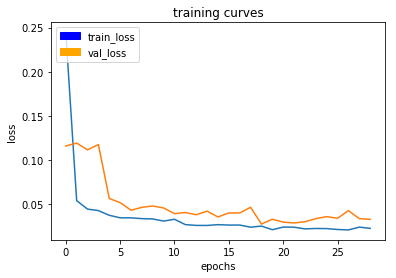

100/100 [==============================] - 100s - loss: 0.0227 - val_loss: 0.0329
Epoch 30/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0195

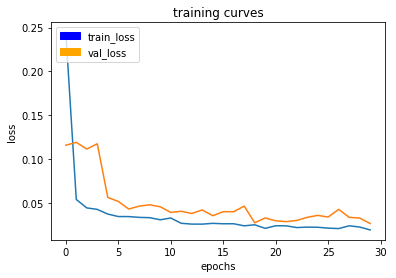

100/100 [==============================] - 101s - loss: 0.0195 - val_loss: 0.0267
Epoch 31/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0227

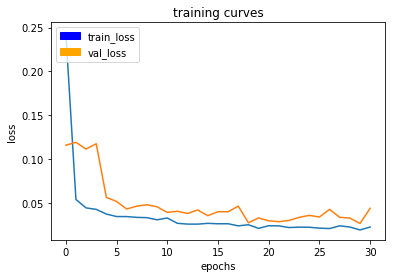

100/100 [==============================] - 101s - loss: 0.0227 - val_loss: 0.0441
Epoch 32/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0199

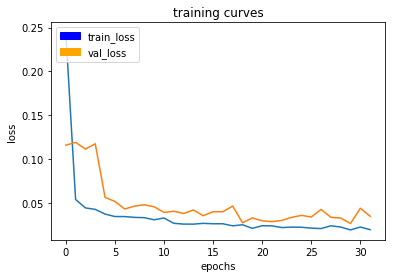

100/100 [==============================] - 101s - loss: 0.0198 - val_loss: 0.0350
Epoch 33/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0217

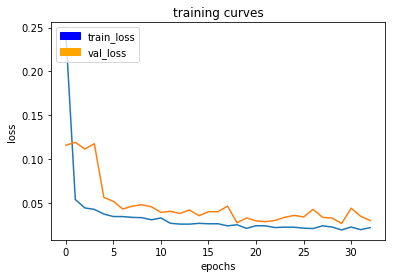

100/100 [==============================] - 100s - loss: 0.0220 - val_loss: 0.0300
Epoch 34/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0203

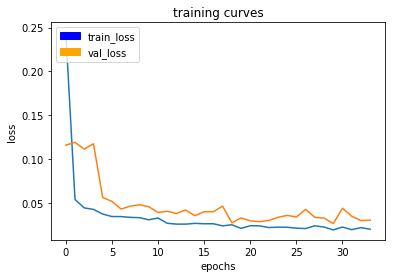

100/100 [==============================] - 100s - loss: 0.0203 - val_loss: 0.0305
Epoch 35/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0188

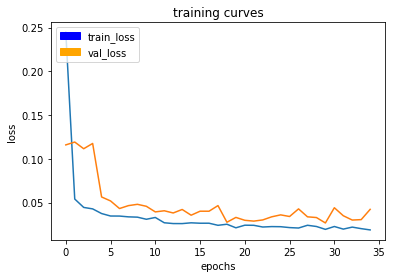

100/100 [==============================] - 101s - loss: 0.0188 - val_loss: 0.0423
Epoch 36/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0198

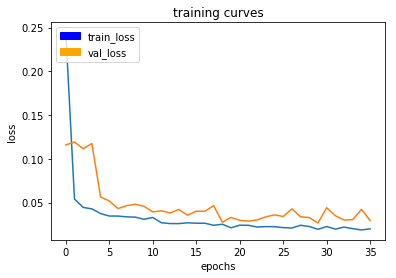

100/100 [==============================] - 100s - loss: 0.0200 - val_loss: 0.0295
Epoch 37/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0222

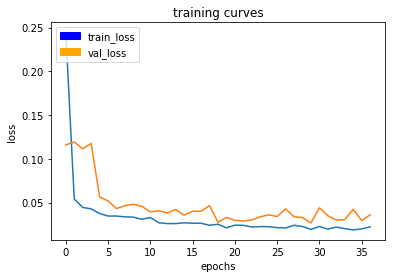

100/100 [==============================] - 100s - loss: 0.0222 - val_loss: 0.0360
Epoch 38/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0216

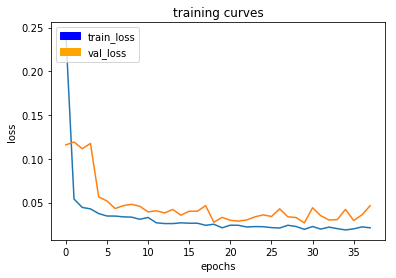

100/100 [==============================] - 100s - loss: 0.0218 - val_loss: 0.0464
Epoch 39/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0192

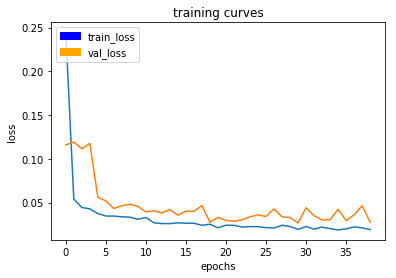

100/100 [==============================] - 101s - loss: 0.0192 - val_loss: 0.0275
Epoch 40/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0190

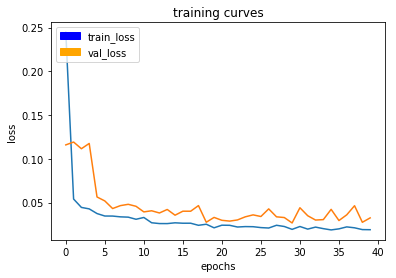

100/100 [==============================] - 101s - loss: 0.0190 - val_loss: 0.0325
Epoch 41/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0179

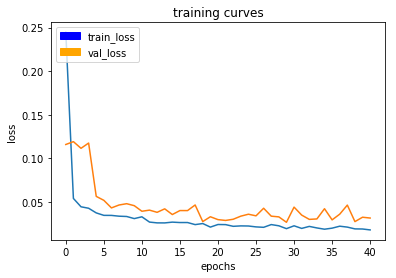

100/100 [==============================] - 101s - loss: 0.0179 - val_loss: 0.0316
Epoch 42/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0180

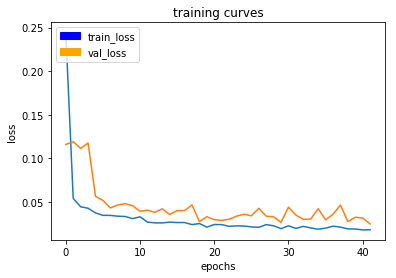

100/100 [==============================] - 100s - loss: 0.0180 - val_loss: 0.0248
Epoch 43/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0189

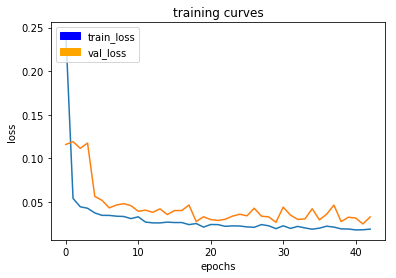

100/100 [==============================] - 100s - loss: 0.0188 - val_loss: 0.0328
Epoch 44/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0190

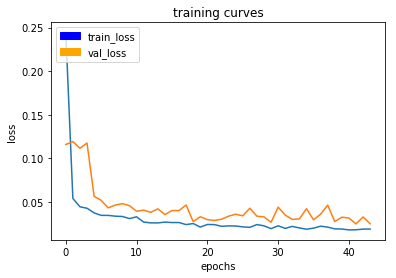

100/100 [==============================] - 101s - loss: 0.0189 - val_loss: 0.0249
Epoch 45/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0161

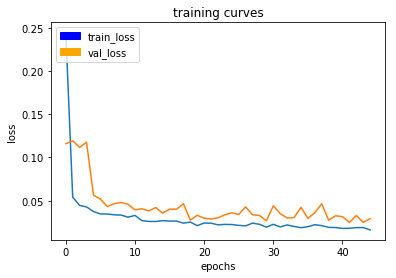

100/100 [==============================] - 101s - loss: 0.0162 - val_loss: 0.0292
Epoch 46/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0197

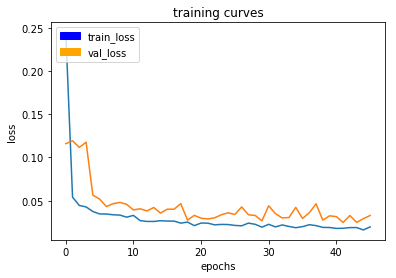

100/100 [==============================] - 100s - loss: 0.0197 - val_loss: 0.0329
Epoch 47/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0179

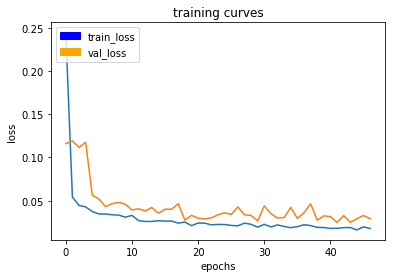

100/100 [==============================] - 100s - loss: 0.0179 - val_loss: 0.0291
Epoch 48/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0167

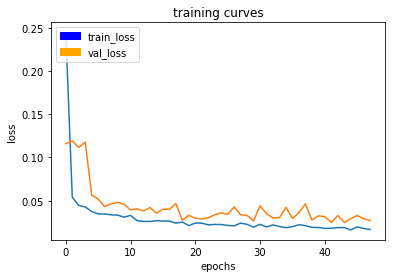

100/100 [==============================] - 101s - loss: 0.0167 - val_loss: 0.0271
Epoch 49/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0175

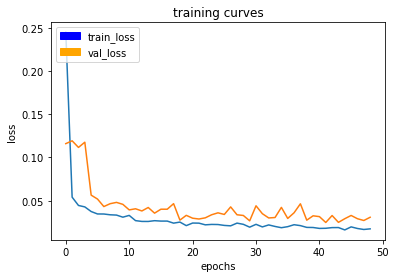

100/100 [==============================] - 100s - loss: 0.0175 - val_loss: 0.0308
Epoch 50/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0179

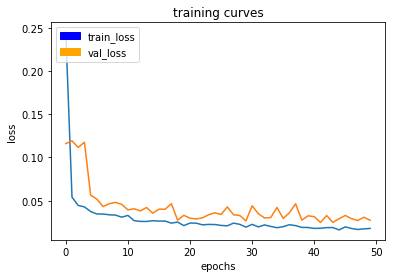

100/100 [==============================] - 101s - loss: 0.0179 - val_loss: 0.0274
Epoch 51/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0166

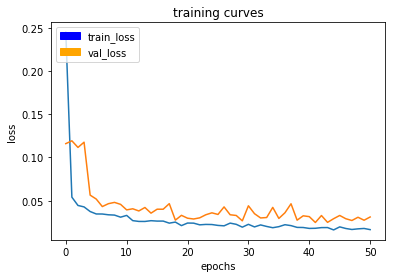

100/100 [==============================] - 101s - loss: 0.0166 - val_loss: 0.0312
Epoch 52/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0165

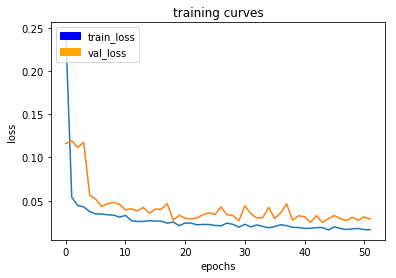

100/100 [==============================] - 100s - loss: 0.0165 - val_loss: 0.0288
Epoch 53/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0165

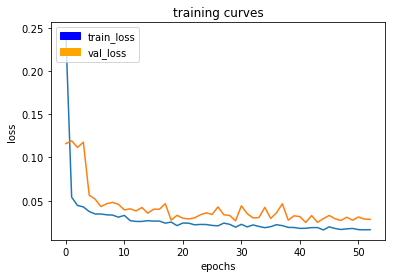

100/100 [==============================] - 101s - loss: 0.0165 - val_loss: 0.0285
Epoch 54/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0189

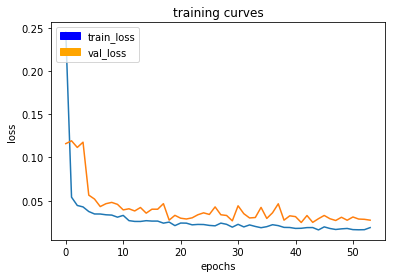

100/100 [==============================] - 100s - loss: 0.0189 - val_loss: 0.0275
Epoch 55/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0147

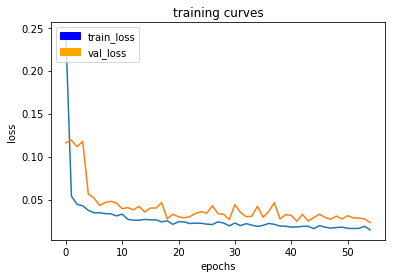

100/100 [==============================] - 101s - loss: 0.0147 - val_loss: 0.0232
Epoch 56/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0168

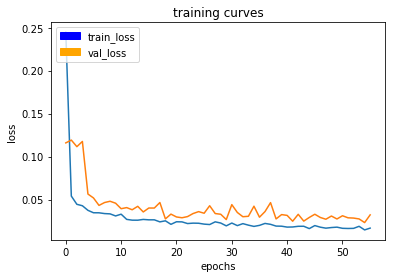

100/100 [==============================] - 101s - loss: 0.0167 - val_loss: 0.0322
Epoch 57/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0157

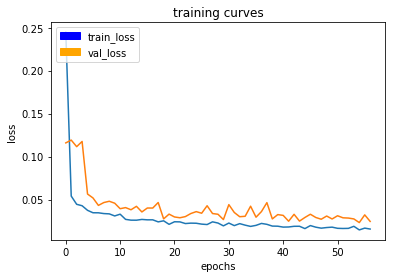

100/100 [==============================] - 102s - loss: 0.0157 - val_loss: 0.0246
Epoch 58/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0143

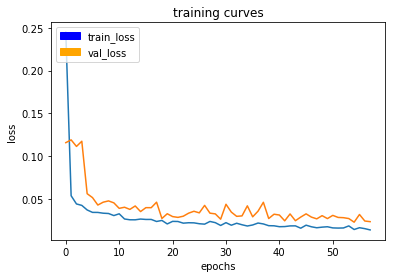

100/100 [==============================] - 101s - loss: 0.0143 - val_loss: 0.0238
Epoch 59/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0174

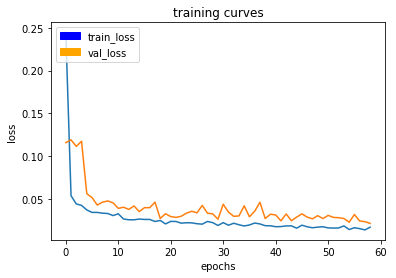

100/100 [==============================] - 100s - loss: 0.0174 - val_loss: 0.0218
Epoch 60/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0147

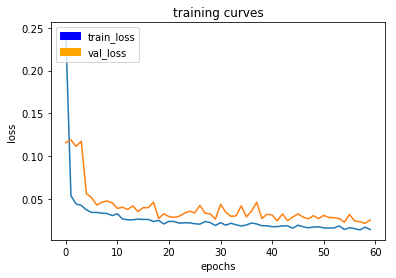

100/100 [==============================] - 100s - loss: 0.0147 - val_loss: 0.0257
Epoch 61/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0150

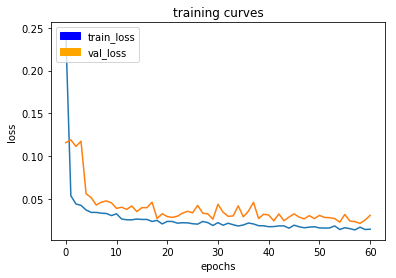

100/100 [==============================] - 101s - loss: 0.0150 - val_loss: 0.0312
Epoch 62/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0176

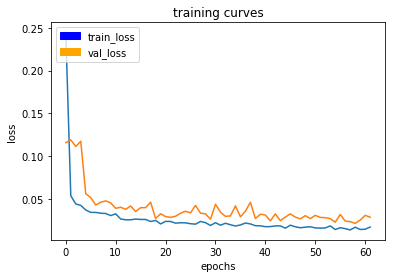

100/100 [==============================] - 100s - loss: 0.0175 - val_loss: 0.0290
Epoch 63/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0154

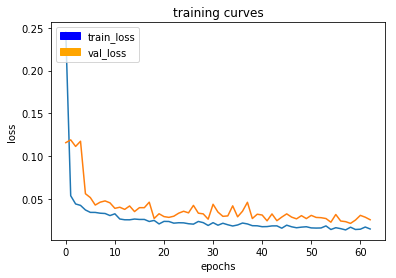

100/100 [==============================] - 100s - loss: 0.0154 - val_loss: 0.0261
Epoch 64/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0158

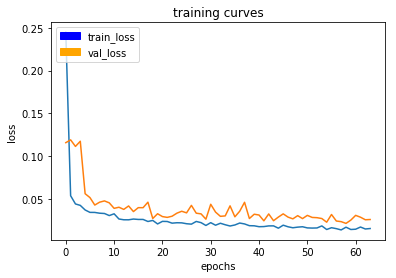

100/100 [==============================] - 101s - loss: 0.0158 - val_loss: 0.0263
Epoch 65/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0148

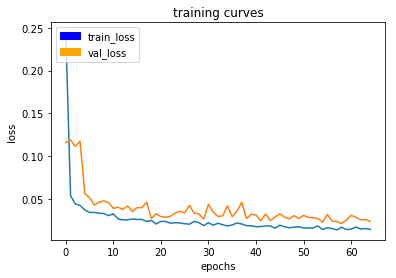

100/100 [==============================] - 101s - loss: 0.0148 - val_loss: 0.0241
Epoch 66/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0168

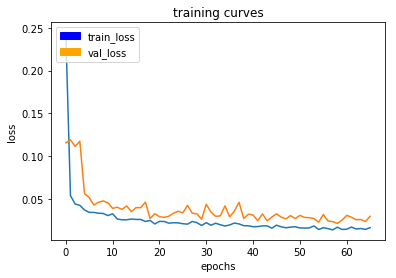

100/100 [==============================] - 102s - loss: 0.0169 - val_loss: 0.0301
Epoch 67/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0156

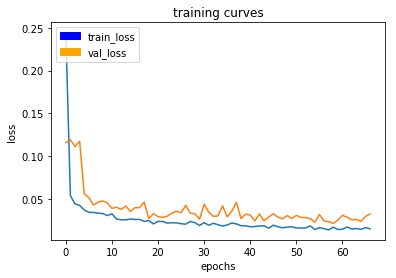

100/100 [==============================] - 100s - loss: 0.0156 - val_loss: 0.0328
Epoch 68/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0157

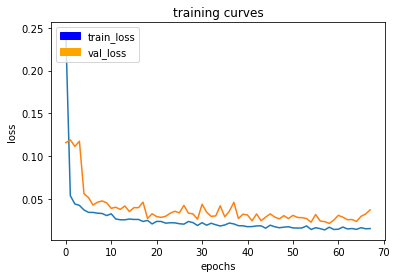

100/100 [==============================] - 101s - loss: 0.0157 - val_loss: 0.0375
Epoch 69/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0144

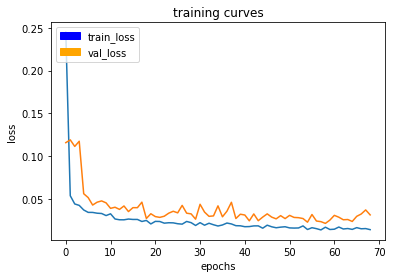

100/100 [==============================] - 101s - loss: 0.0146 - val_loss: 0.0317
Epoch 70/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0142

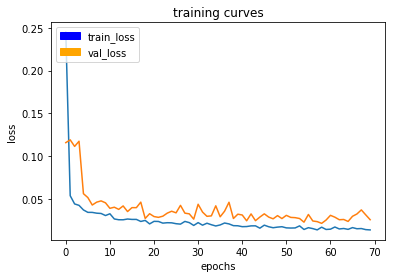

100/100 [==============================] - 101s - loss: 0.0142 - val_loss: 0.0261
Epoch 71/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0133

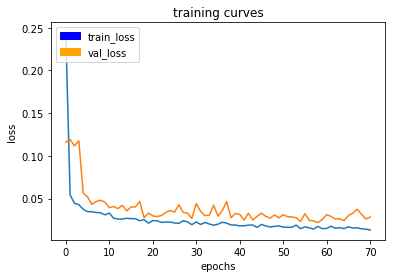

100/100 [==============================] - 100s - loss: 0.0133 - val_loss: 0.0283
Epoch 72/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0175

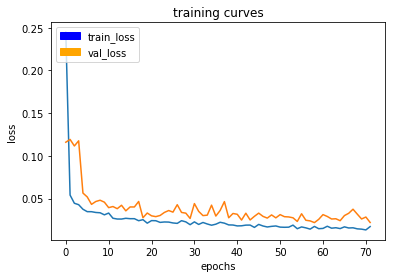

100/100 [==============================] - 101s - loss: 0.0174 - val_loss: 0.0220
Epoch 73/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0160

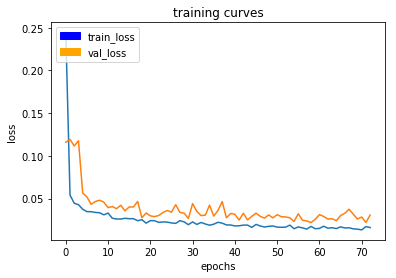

100/100 [==============================] - 100s - loss: 0.0160 - val_loss: 0.0306
Epoch 74/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0143

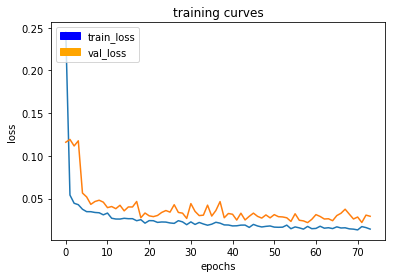

100/100 [==============================] - 101s - loss: 0.0142 - val_loss: 0.0292
Epoch 75/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0129

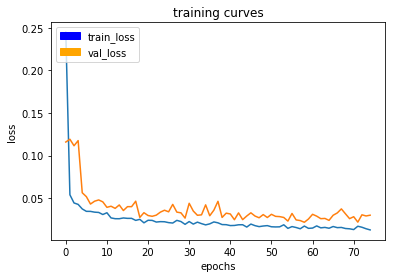

100/100 [==============================] - 100s - loss: 0.0129 - val_loss: 0.0301
Epoch 76/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0161

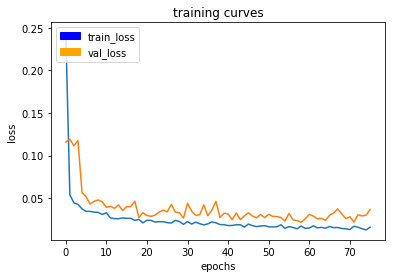

100/100 [==============================] - 100s - loss: 0.0161 - val_loss: 0.0369
Epoch 77/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0168

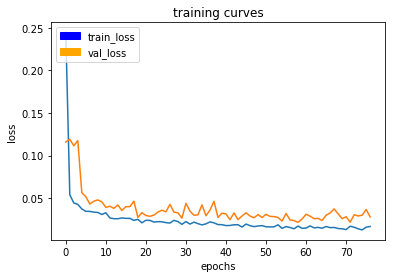

100/100 [==============================] - 100s - loss: 0.0168 - val_loss: 0.0281
Epoch 78/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0144

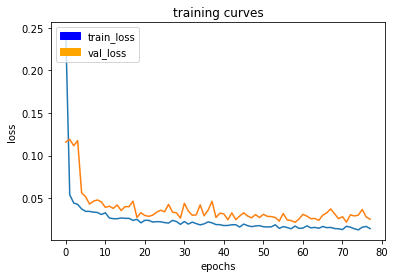

100/100 [==============================] - 100s - loss: 0.0144 - val_loss: 0.0254
Epoch 79/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0127

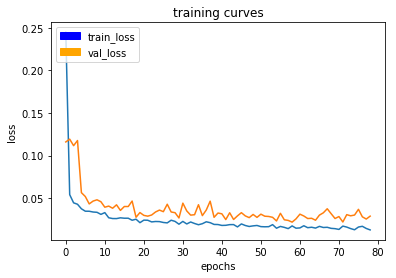

100/100 [==============================] - 101s - loss: 0.0127 - val_loss: 0.0289
Epoch 80/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0160

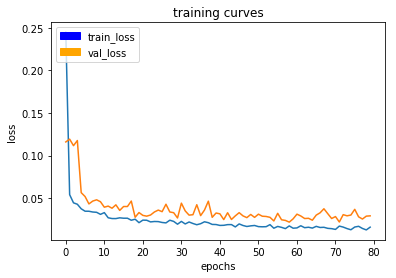

100/100 [==============================] - 100s - loss: 0.0159 - val_loss: 0.0292
Epoch 81/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0146

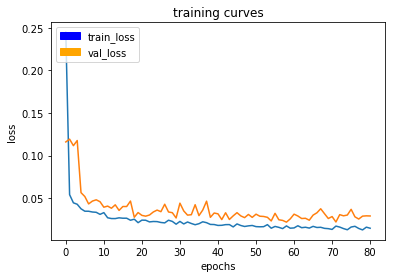

100/100 [==============================] - 101s - loss: 0.0146 - val_loss: 0.0291
Epoch 82/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0137

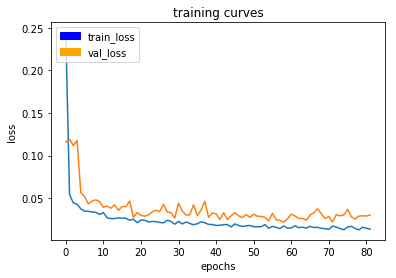

100/100 [==============================] - 101s - loss: 0.0137 - val_loss: 0.0301
Epoch 83/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0131

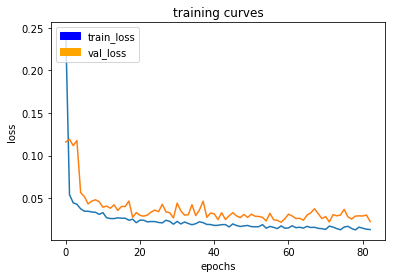

100/100 [==============================] - 101s - loss: 0.0131 - val_loss: 0.0225
Epoch 84/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0144

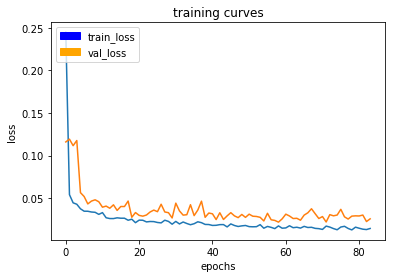

100/100 [==============================] - 101s - loss: 0.0144 - val_loss: 0.0257
Epoch 85/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0141

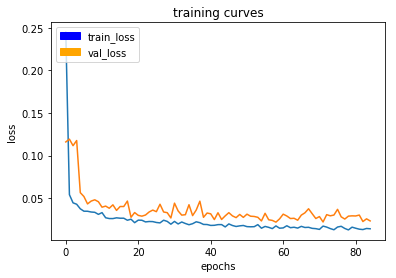

100/100 [==============================] - 101s - loss: 0.0141 - val_loss: 0.0232
Epoch 86/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0213

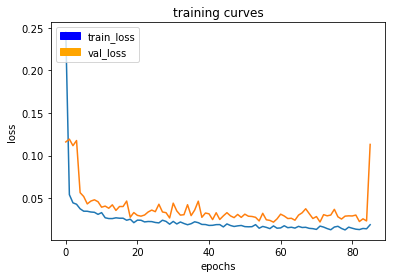

100/100 [==============================] - 101s - loss: 0.0213 - val_loss: 0.1130
Epoch 87/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0255

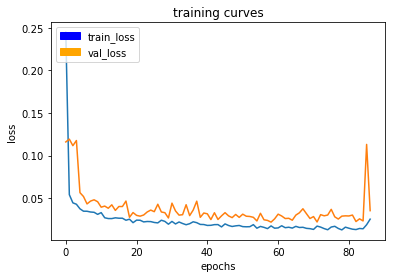

100/100 [==============================] - 101s - loss: 0.0253 - val_loss: 0.0353
Epoch 88/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0171

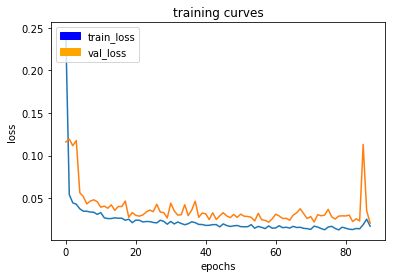

100/100 [==============================] - 100s - loss: 0.0171 - val_loss: 0.0207
Epoch 89/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0167

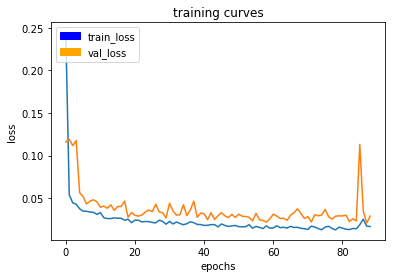

100/100 [==============================] - 101s - loss: 0.0167 - val_loss: 0.0290
Epoch 90/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0169

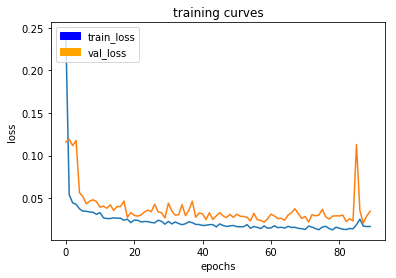

100/100 [==============================] - 101s - loss: 0.0169 - val_loss: 0.0346
Epoch 91/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0156

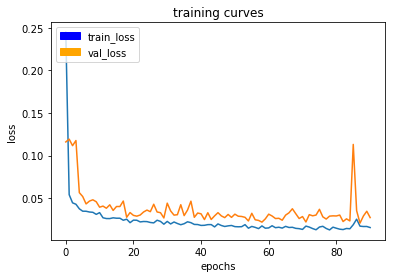

100/100 [==============================] - 100s - loss: 0.0155 - val_loss: 0.0271
Epoch 92/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0137

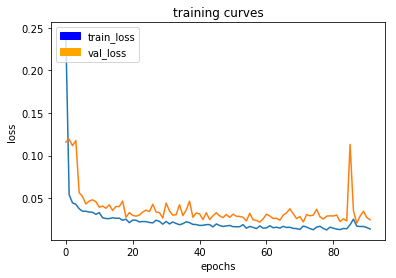

100/100 [==============================] - 101s - loss: 0.0137 - val_loss: 0.0247
Epoch 93/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0138

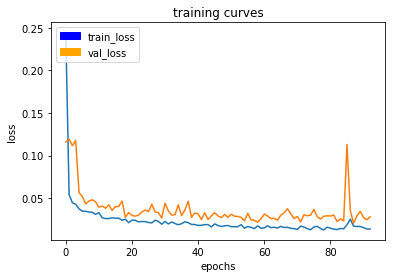

100/100 [==============================] - 100s - loss: 0.0137 - val_loss: 0.0279
Epoch 94/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0169

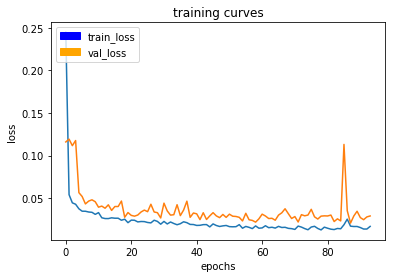

100/100 [==============================] - 100s - loss: 0.0168 - val_loss: 0.0291
Epoch 95/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0130

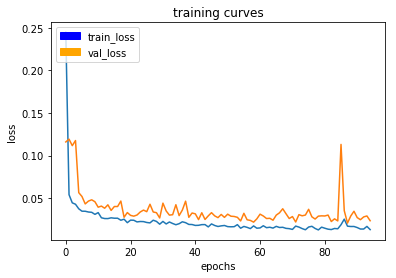

100/100 [==============================] - 101s - loss: 0.0130 - val_loss: 0.0235
Epoch 96/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0126

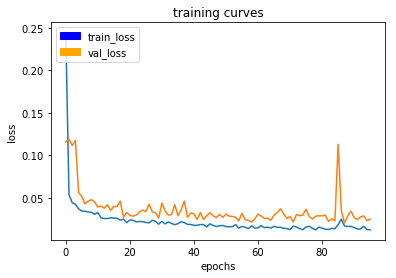

100/100 [==============================] - 101s - loss: 0.0126 - val_loss: 0.0253
Epoch 97/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0116

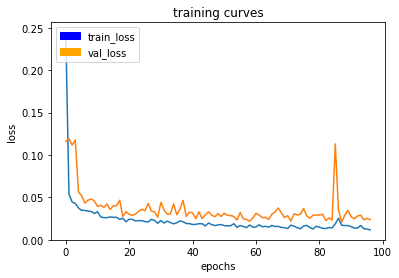

100/100 [==============================] - 100s - loss: 0.0116 - val_loss: 0.0238
Epoch 98/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0135

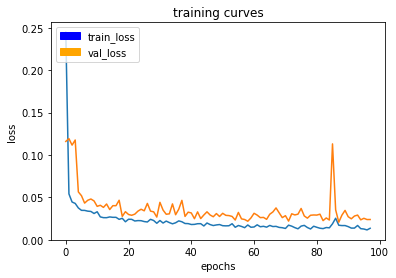

100/100 [==============================] - 101s - loss: 0.0135 - val_loss: 0.0239
Epoch 99/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0127

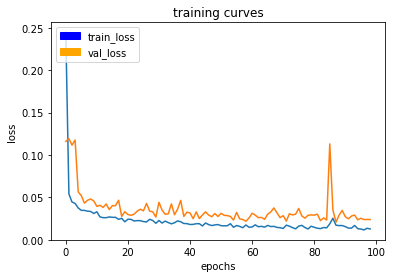

100/100 [==============================] - 101s - loss: 0.0127 - val_loss: 0.0238
Epoch 100/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0130

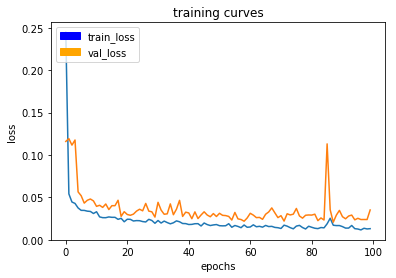

100/100 [==============================] - 101s - loss: 0.0130 - val_loss: 0.0351


In [27]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# Define the Keras model and compile it for training
model = models.Model(inputs=inputs, outputs=output_layer)

model.compile(optimizer=keras.optimizers.Adam(learning_rate), loss='categorical_crossentropy')

# Data iterators for loading the training and validation data
train_iter = data_iterator.BatchIteratorSimple(batch_size=batch_size,
                                               data_folder=os.path.join('..', 'data', 'train'),
                                               image_shape=image_shape,
                                               shift_aug=True)

val_iter = data_iterator.BatchIteratorSimple(batch_size=batch_size,
                                             data_folder=os.path.join('..', 'data', 'validation'),
                                             image_shape=image_shape)

logger_cb = plotting_tools.LoggerPlotter()
callbacks = [logger_cb]

model.fit_generator(train_iter,
                    steps_per_epoch = steps_per_epoch, # the number of batches per epoch,
                    epochs = num_epochs, # the number of epochs to train for,
                    validation_data = val_iter, # validation iterator
                    validation_steps = validation_steps, # the number of batches to validate on
                    callbacks=callbacks,
                    workers = workers)

In [28]:
# Save your trained model weights
weight_file_name = 'model_weights'
model_tools.save_network(model, weight_file_name)

## Prediction <a id='prediction'></a>

Now that you have your model trained and saved, you can make predictions on your validation dataset. These predictions can be compared to the mask images, which are the ground truth labels, to evaluate how well your model is doing under different conditions.

There are three different predictions available from the helper code provided:
- **patrol_with_targ**: Test how well the network can detect the hero from a distance.
- **patrol_non_targ**: Test how often the network makes a mistake and identifies the wrong person as the target.
- **following_images**: Test how well the network can identify the target while following them.

In [29]:
# If you need to load a model which you previously trained you can uncomment the codeline that calls the function below.

# weight_file_name = 'model_weights'
# restored_model = model_tools.load_network(weight_file_name)

The following cell will write predictions to files and return paths to the appropriate directories.
The `run_num` parameter is used to define or group all the data for a particular model run. You can change it for different runs. For example, 'run_1', 'run_2' etc.

In [30]:
run_num = 'run_1'

val_with_targ, pred_with_targ = model_tools.write_predictions_grade_set(model,
                                        run_num,'patrol_with_targ', 'sample_evaluation_data') 

val_no_targ, pred_no_targ = model_tools.write_predictions_grade_set(model, 
                                        run_num,'patrol_non_targ', 'sample_evaluation_data') 

val_following, pred_following = model_tools.write_predictions_grade_set(model,
                                        run_num,'following_images', 'sample_evaluation_data')

Now lets look at your predictions, and compare them to the ground truth labels and original images.
Run each of the following cells to visualize some sample images from the predictions in the validation set.

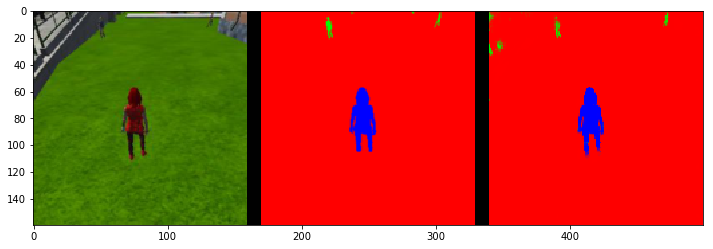

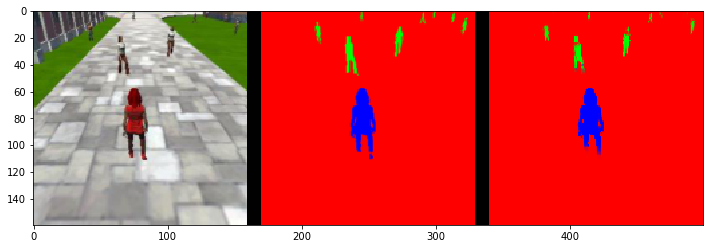

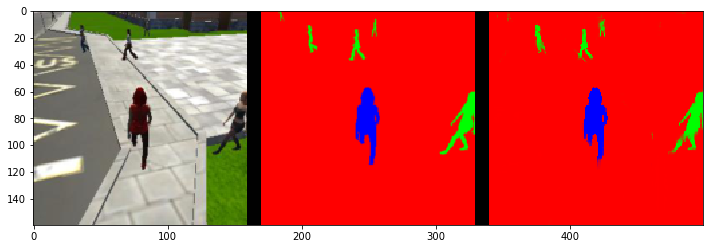

In [31]:
# images while following the target
im_files = plotting_tools.get_im_file_sample('sample_evaluation_data','following_images', run_num) 
for i in range(3):
    im_tuple = plotting_tools.load_images(im_files[i])
    plotting_tools.show_images(im_tuple)
    

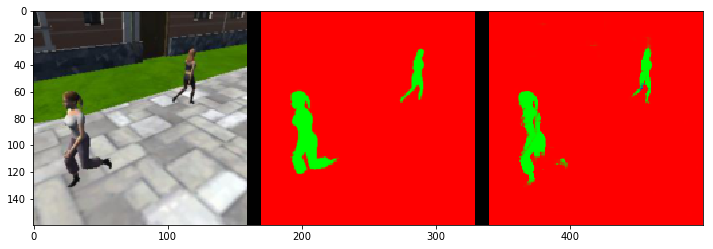

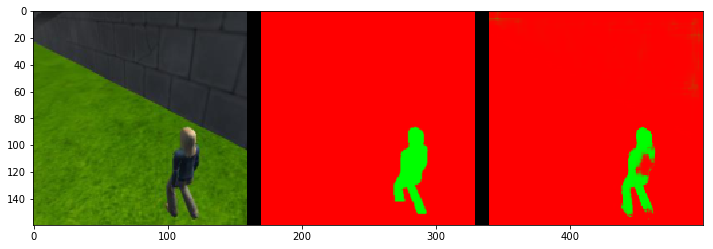

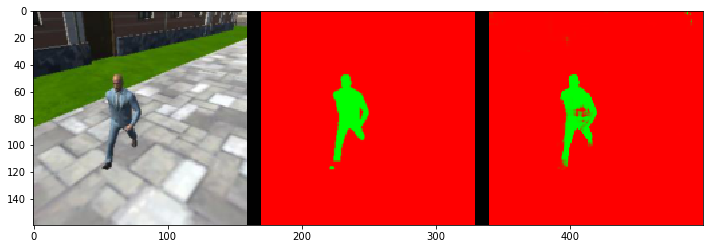

In [32]:
# images while at patrol without target
im_files = plotting_tools.get_im_file_sample('sample_evaluation_data','patrol_non_targ', run_num) 
for i in range(3):
    im_tuple = plotting_tools.load_images(im_files[i])
    plotting_tools.show_images(im_tuple)
 

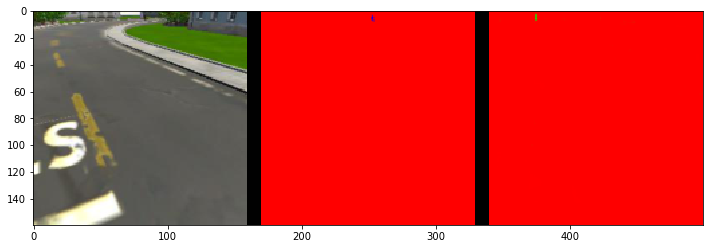

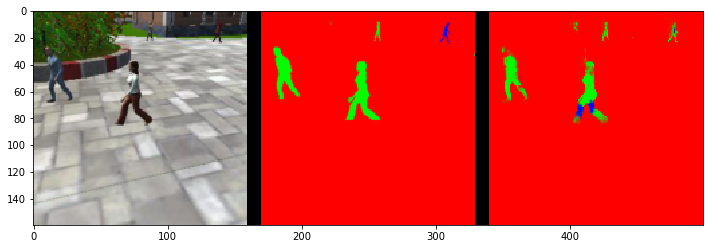

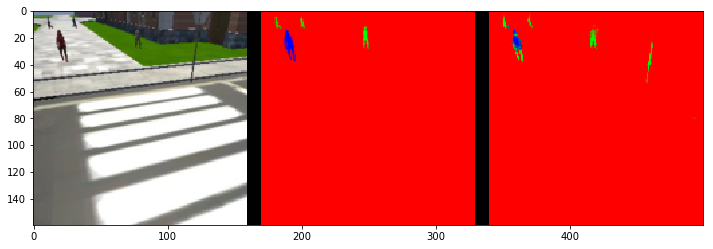

In [33]:
   
# images while at patrol with target
im_files = plotting_tools.get_im_file_sample('sample_evaluation_data','patrol_with_targ', run_num) 
for i in range(3):
    im_tuple = plotting_tools.load_images(im_files[i])
    plotting_tools.show_images(im_tuple)

## Evaluation <a id='evaluation'></a>
Evaluate your model! The following cells include several different scores to help you evaluate your model under the different conditions discussed during the Prediction step. 

In [34]:
# Scores for while the quad is following behind the target. 
true_pos1, false_pos1, false_neg1, iou1 = scoring_utils.score_run_iou(val_following, pred_following)

number of validation samples intersection over the union evaulated on 542
average intersection over union for background is 0.9962409131746885
average intersection over union for other people is 0.37379016081622124
average intersection over union for the hero is 0.8973378751398002
number true positives: 539, number false positives: 0, number false negatives: 0


In [35]:
# Scores for images while the quad is on patrol and the target is not visable
true_pos2, false_pos2, false_neg2, iou2 = scoring_utils.score_run_iou(val_no_targ, pred_no_targ)

number of validation samples intersection over the union evaulated on 270
average intersection over union for background is 0.9881917647009099
average intersection over union for other people is 0.764714210690277
average intersection over union for the hero is 0.0
number true positives: 0, number false positives: 49, number false negatives: 0


In [36]:
# This score measures how well the neural network can detect the target from far away
true_pos3, false_pos3, false_neg3, iou3 = scoring_utils.score_run_iou(val_with_targ, pred_with_targ)

number of validation samples intersection over the union evaulated on 322
average intersection over union for background is 0.996933138839657
average intersection over union for other people is 0.4793212539945499
average intersection over union for the hero is 0.24450668791135174
number true positives: 134, number false positives: 1, number false negatives: 167


In [37]:
# Sum all the true positives, etc from the three datasets to get a weight for the score
true_pos = true_pos1 + true_pos2 + true_pos3
false_pos = false_pos1 + false_pos2 + false_pos3
false_neg = false_neg1 + false_neg2 + false_neg3

weight = true_pos/(true_pos+false_neg+false_pos)
print(weight)

0.7561797752808989


In [38]:
# The IoU for the dataset that never includes the hero is excluded from grading
final_IoU = (iou1 + iou3)/2
print(final_IoU)

0.570922281526


In [39]:
# And the final grade score is 
final_score = final_IoU * weight
print(final_score)

0.431719882547
